# The one-dimensional energy balance model

This notebook is heavily based on [Lecture 19](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/heat-transport.html) and [Lecture 20](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/one-dim-ebm.html) of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

**Recap:** So far we discussed 
 - 0-dimensional Energy Balance Models
 - elementary Greenhouse Models (with 1 and 2 atmospheric layers)
 
These models did not include any horizontal extent and resolution, which were represented by an _averaged single point mass_ instead. Today we are extending the 0-dimensional EBM by one horizontal dimension: *latitue* (north <-> south).

____________
<a id='section1'></a>

## 1. Spatial patterns of insolation and surface temperature
____________

Let's take a look at _seasonal and spatial pattern of insolation_ and compare this to the _zonal average surface temperatures_.

Climlab has a very handy routine to compute the daily average insolation pattern for each latitute and day per year. If you want to know more on how climlab does this computation, have a look at the [documentation](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.insolation.html#climlab.radiation.insolation.DailyInsolation).

For the zonal average surface temperatures, we use the [NCEP reanalysis data](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html), as in the last notebook.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const

AttributeError: 'TlzSpec' object has no attribute '_uninitialized_submodules'

In [ ]:
#  Calculate daily average insolation as function of latitude and time of year
lat = np.linspace( -90., 90., 500 )
days = np.linspace(0, const.days_per_year, 365 )
Q = climlab.solar.insolation.daily_insolation( lat, days )

In [3]:
#  daily surface temperature from  NCEP reanalysis
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_temp = xr.open_dataset( ncep_url + "surface_gauss/skt.sfc.day.1981-2010.ltm.nc", decode_times=False)
ncep_temp_zon = ncep_temp.skt.mean(dim='lon')

NameError: name 'xr' is not defined

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
CS = ax1.contour( days, lat, Q , levels = np.arange(0., 600., 50.) )
ax1.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax1.set_title('Daily average insolation', fontsize=18 )
ax1.contourf ( days, lat, Q, levels=[-100., 0.], colors='k' )

ax2 = fig.add_subplot(122)
CS = ax2.contour( (ncep_temp.time - ncep_temp.time[0])/const.hours_per_day, ncep_temp.lat, 
                 ncep_temp_zon.T, levels=np.arange(210., 310., 10. ) )
ax2.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax2.set_title('Observed zonal average surface temperature', fontsize=18 )

for ax in [ax1,ax2]:
    ax.set_xlabel('Days since January 1', fontsize=16 )
    ax.set_ylabel('Latitude', fontsize=16 )
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.grid()

This figure reveals something fairly obvious, but still worth thinking about:

**Warm temperatures are correlated with high insolation**. It's warm where the sun shines.

More specifically, we can see a few interesting details here:

- The seasonal cycle is weakest in the tropics and strongest in the high latitudes.
- The warmest temperatures occur slighly NORTH of the equator
- The highest insolation occurs at the poles at summer solstice.

The local surface temperature does not correlate perfectly with local insolation for two reasons:

- the climate system has heat capacity, which buffers some of the seasonal variations
- the climate system moves energy around in space!

### Create climlab model with daily insolation
Let's create a climlab model which accounts for daily insolation. 
We use Stefan Boltzmann OLR and fixed albedo for now (and care about this later).

In [ ]:
# A one-dimensional domain
state = climlab.surface_state(num_lat=90, water_depth=10.)

#  Daily insolation as a function of latitude and time of year
sun = climlab.radiation.DailyInsolation(name='Insolation', domains=state['Ts'].domain)

#  create the longwave radiation process
olr = climlab.radiation.Boltzmann(name='OutgoingLongwave',
                                  state=state, 
                                  tau = 0.612,
                                  eps = 1.,
                                )

#  create the shortwave radiation process
asr = climlab.radiation.SimpleAbsorbedShortwave(name='AbsorbedShortwave',
                                                state=state, 
                                                insolation=sun.insolation, 
                                                albedo=0.299,
                                               )


ins_model = climlab.couple([sun, olr,asr], name='1dEBM')
print( ins_model)

In [ ]:
ins_model.compute_diagnostics()

In [ ]:
fig, ax = plt.subplots()
ax.plot(ins_model.lat, ins_model.insolation)
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');

This new insolation process uses the same code we've already been working with to compute realistic distributions of insolation. Here we are using
```
climlab.radiation.DailyInsolation
```
but there is also

```
climlab.radiation.AnnualMeanInsolation
```
for models in which you prefer to suppress the seasonal cycle and prescribe a time-invariant insolation.

The following code will just integrate the model forward in four steps in order to get snapshots of insolation at the solstices and equinoxes.

In [ ]:
#  ins_model is initialized on Jan. 1

#  integrate forward just under 1/4 year... should get about to the NH spring equinox
ins_model.integrate_days(31+28+22)
Q_spring = ins_model.insolation.copy()
#  Then forward to NH summer solstice
ins_model.integrate_days(31+30+31)
Q_summer = ins_model.insolation.copy()
#  and on to autumnal equinox
ins_model.integrate_days(30+31+33)
Q_fall = ins_model.insolation.copy()
#  and finally to NH winter solstice
ins_model.integrate_days(30+31+30)
Q_winter = ins_model.insolation.copy()

In [ ]:
fig, ax = plt.subplots()
ax.plot(ins_model.lat, Q_spring, label='Spring')
ax.plot(ins_model.lat, Q_summer, label='Summer')
ax.plot(ins_model.lat, Q_fall, label='Fall')
ax.plot(ins_model.lat, Q_winter, label='Winter')
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');

This just serves to demonstrate that the `DailyInsolation` process is doing something sensible.

Note that we could also pass different orbital parameters to this subprocess. They default to present-day values, which is what we are using here.

____

<a id='section2'></a>

## 2. Parameterising OLR as a function of latitude
____

So far we have used the Stefan Boltzmann radiation law to calculate the mean Outgoing Longwave Radiation as a function of surface temperature, taking the opacity & emissivity of the atmosphere into account with a tuned parameter $\epsilon$.

$$ OLR = \sigma \ \epsilon \ T_s^4 $$

Let's see how well this relation works for observed OLR (for different latitudes and surface temperatures), using the NCEP reanalysis data again:

In [2]:
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"

# monthly surface temperature
ncep_Ts = xr.open_dataset( ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc", decode_times=False)
lat_ncep = ncep_Ts.lat; lon_ncep = ncep_Ts.lon
ncep_Ts

NameError: name 'xr' is not defined

In [ ]:
#  Take the annual and zonal average!
Ts_ncep_annual = ncep_Ts.skt.mean(dim=('lon','time'))

In [ ]:
# TOA radiation data
ncep_ulwrf = xr.open_dataset( ncep_url + "other_gauss/ulwrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
ncep_dswrf = xr.open_dataset( ncep_url + "other_gauss/dswrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
ncep_uswrf = xr.open_dataset( ncep_url + "other_gauss/uswrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
OLR_ncep_annual = ncep_ulwrf.ulwrf.mean(dim=('lon','time'))
ASR_ncep_annual = (ncep_dswrf.dswrf - ncep_uswrf.uswrf).mean(dim=('lon','time'))

In [ ]:
OLR_boltzmann = climlab.constants.sigma * 0.61 * (Ts_ncep_annual+273.15)**4

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot( Ts_ncep_annual, OLR_ncep_annual, 'o' , label='observation')
ax1.plot(Ts_ncep_annual, OLR_boltzmann, label='Boltzmann')
ax1.set_xlabel('Surface temperature (C)', fontsize=16)
ax1.set_ylabel('OLR (W m$^{-2}$)', fontsize=16)
ax1.set_title('OLR versus surface temperature from NCEP reanalysis', fontsize=18)
ax1.legend(loc='upper left')
ax1.grid()

The Stefan Boltzmann law works well for the temperature range between 5 and 25$^\circ$C, but not above and below. This is due to the complex atmospheric processes that affect atmospheric absorption of longwave radiation. The most obvious is the impact of cloud bands around the equator which reduces OLR for highest surface temperatures.

Instead of an exponential OLR scaling with surface temperature, let's introduce the following simple linear parameterization:

$$ OLR = A + B T_s $$

With:

- $T_s$ the zonal average surface temperature in ºC
- $A$ is a constant in W m$^{-2}$
- $B$ is a constant in W m$^{-2}$ ºC$^{-1}$


Let's use linear regression to compute this:

In [ ]:
#  Use a linear regression package to compute best fit for the slope and intercept
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(Ts_ncep_annual, OLR_ncep_annual)

print( 'Best fit is A = %0.0f W/m2 and B = %0.1f W/m2/degC' %(intercept, slope))

We're going to plot the data and the best fit line, but also another line using these values:

In [ ]:
#  More standard values
A = 210.
B = 2.

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot( Ts_ncep_annual, OLR_ncep_annual, 'o' , label='data')
ax1.plot( Ts_ncep_annual, intercept + slope * Ts_ncep_annual, 'k--', label='best fit')
ax1.plot( Ts_ncep_annual, A + B * Ts_ncep_annual, 'r--', label='B=2')
ax1.plot(Ts_ncep_annual, OLR_boltzmann, label='Boltzmann')
ax1.set_xlabel('Surface temperature (C)', fontsize=16)
ax1.set_ylabel('OLR (W m$^{-2}$)', fontsize=16)
ax1.set_title('OLR versus surface temperature from NCEP reanalysis', fontsize=18)
ax1.legend(loc='upper left')
ax1.grid()

____

<a id='section3'></a>

## 3. Parameterising albedo as a function of latitude
____

### Observed albedo

Let's go back to the NCEP Reanalysis data to see how planetary albedo actually varies as a function of latitude.

In [ ]:
days = np.linspace(1.,50.)/50 * const.days_per_year
Qann_ncep = climlab.solar.insolation.daily_insolation(lat_ncep, days ).mean(dim='day')
albedo_ncep = 1 - ASR_ncep_annual / Qann_ncep

albedo_ncep_global = np.average(albedo_ncep, weights=np.cos(np.deg2rad(lat_ncep)))

In [ ]:
print( 'The annual, global mean planetary albedo is %0.3f' %albedo_ncep_global)
fig,ax = plt.subplots()
ax.plot(lat_ncep, albedo_ncep)
ax.grid();
ax.set_xlabel('Latitude')
ax.set_ylabel('Albedo');

**The albedo increases markedly toward the poles.**

There are several reasons for this:

- Surface snow and ice increase toward the poles
- Cloudiness is an important (but complicated) factor.
- Albedo increases with solar zenith angle (the angle at which the direct solar beam strikes a surface)

### Approximating the observed albedo with a smooth function

Like temperature and insolation, this can be approximated by a smooth function that increases with latitude:

$$ \alpha(\phi) \approx \alpha_0 + \alpha_2 P_2(\sin\phi) $$

where $P_2$ is the 2nd Legendre polynomial:

$$ P_2 (x) = \frac{1}{2} \left( 3x^2-1 \right) $$

where we have also set

$$ x = \sin\phi $$

In effect we are using a truncated series expansion of the full meridional structure of $\alpha$. $a_0$ is the global average, and $a_2$ is proportional to the equator-to-pole gradient in $\alpha$.

We will set

$$ \alpha_0 = 0.354, ~~~ \alpha_2 = 0.25 $$

In [ ]:
# Add a new curve to the previous figure
from climlab.utils import legendre

a0 = albedo_ncep_global
a2 = 0.25
ax.plot(lat_ncep, a0 + a2 * legendre.P2(np.sin(np.deg2rad(lat_ncep))))
fig

Of course we are not fitting all the details of the observed albedo curve. But we do get the correct global mean a reasonable representation of the equator-to-pole gradient in albedo.

____

<a id='section4'></a>

## 4. Building a 1-dim EBM
____

Okay, now that we have latitude dependent parameterisations of 
 - Outgoing Longwave Radiation
 - Insulation
 - albedo
 
let's put things together and see what surface temperatures this one dimensional EBM computes. 

In [ ]:
# A two-dimensional domain
state = climlab.surface_state(num_lat=90, water_depth=10.)

#  create the longwave radiation process
olr = climlab.radiation.AplusBT(name='OutgoingLongwave',
                                  state=state, 
                                  A = 210,
                                  B = 2)

# create daily insolation as a function of latitude and time of year
sun = climlab.radiation.DailyInsolation(name='Insolation', domains=state['Ts'].domain)

# create latitude dependent albedo parameterisation
alb = climlab.surface.albedo.P2Albedo(domains=state['Ts'].domain,
                                     a0 = 0.354,
                                     a2 = 0.25)

#  create the shortwave radiation process
asr = climlab.radiation.SimpleAbsorbedShortwave(name='AbsorbedShortwave',
                                                state=state, 
                                                insolation=sun.insolation, 
                                                albedo=alb.albedo,
                                               )


model = climlab.couple([olr,asr,sun], name='1dEBM')
print( model)

In [ ]:
climlab.to_xarray(state)

### Find the steady seasonal cycle of temperature

In [ ]:
model.integrate_years(4.)

In [ ]:
model.integrate_years(1.)

All climlab `Process` objects have an attribute called `timeave`. 

This is a dictionary of time-averaged diagnostics, which are automatically calculated during the most recent call to `integrate_years()` or `integrate_days()`.

In [ ]:
model.timeave.keys()

Here we use the `timeave['insolation']` to plot the annual mean insolation. 

(We know it is the *annual* average because the last call to `model.integrate_years` was for exactly 1 year)

In [ ]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['insolation'])
ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_ylabel('Insolation [W/m$^2$]')

###  Compare annual average nodel temperature to the zonal-, annual mean observations.

In [ ]:
# Plot annual mean surface temperature in the model,
#   compare to observed annual mean surface temperatures
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(model.lat, model.timeave['Ts'], label='1d EBM')
ax.plot(ncep_temp_zon.lat, ncep_temp_zon.mean(dim='time')-273.15, label='observation')
ax.set_xticks(range(-90,100,30))
ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_ylabel('T$_s$ [$^\circ$C]')
ax.grid(); ax.legend();

The 1 dimensional EBM is too warm at equator and too cold at the poles, **differing more than 30 $^\circ$C!** Why is that?

Let's compare the energy budget for the model and observations:

TypeError: 'Axes' object is not subscriptable

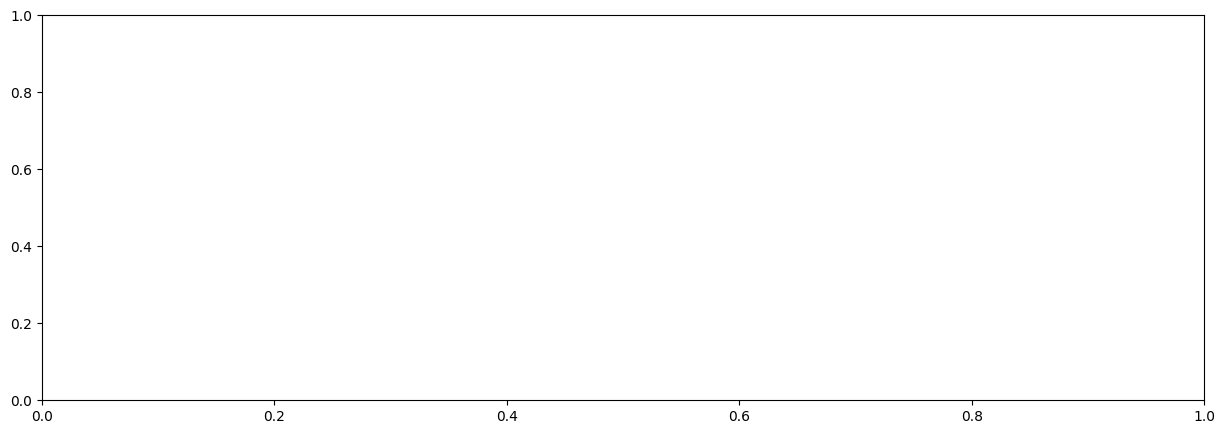

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,1, figsize=(15,5))


ax = axes[0]
ax.plot(lat_ncep, ASR_ncep_annual, label='ASR')
ax.plot(lat_ncep, OLR_ncep_annual, label='OLR')
ax.set_title('observations')
ax.set_xlabel('latitude [$^\circ$N]')
ax.legend()


# ax = axes[1]
# ax.plot(model.lat, model.timeave['ASR'], label='ASR')
# ax.plot(model.lat, model.timeave['OLR'], label='OLR')
# ax.set_title('1dim EBM')
# ax.set_ylabel('radiation [W/m$^2$]')
# ax.set_xlabel('latitude [$^\circ$N]')
# ax.legend()



Observations show that there is an imbalance of radiation energy across latitudes:

- low latitudes (around equator): more shortwave radiation absorbed at the equator than radiated to space -> **energy surplus**
- high latitudes (towards the poles): more long wave radiation emitted than absorbed shortwave radiation -> **energy deficit**

That means energy must be transported from equator to the poles. **We did not include any transport terms across latitude in our 1 dimensional energy balance model** so far.

As a consequence the surface temperature adjust at every single latitude to balance ASR and OLR, leading to too high temperatures around equator and too low temperatures at the poles.



We will look at parameterising energy transport in the next lab.

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________